In [1]:
%matplotlib inline
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
# This function easily plots a boxplot and a countplot of the desired categorical variable
def categorical_analizator(x,y,data,order=None):
    sns.set(rc={'figure.figsize':(10,5)})
    plt.subplot(1, 2, 1)
    sns.boxplot(x=x, y=y, 
                order=order,
                data=data, saturation=0.6)
    plt.title("Boxplot " + y + " Vs " + x)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=x,data=data)
    plt.title("Count of "+x)
    plt.xlabel(x)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.show()

In [3]:
train = pd.read_csv('src/train.csv')
test = pd.read_csv('src/test.csv')

# Data Exploration

In [4]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


In [5]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 80 entries, Id to SaleCondition
dtypes: float64(11), int64(26), object(43)
memory usage: 912.0+ KB


In [7]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
193,194,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,130000
1156,1157,80,RL,85.0,9350,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2008,WD,Normal,179900
824,825,20,FV,81.0,11216,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,232600
992,993,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnWw,NaN,0,7,2007,WD,Normal,187000
26,27,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,134800


In [145]:
#ID variable
train_ID = train['Id']
test_ID = test['Id']

In [146]:
#drop the  'Id' colum 
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Let´s start analysing the target

In [148]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

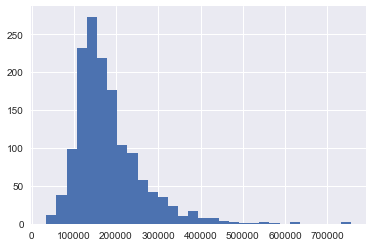

In [149]:
train['SalePrice'].hist(bins=30).plot()
plt.show()

The distribution is right skewed. Usually a log transformation is sufficient to transform this in a normal distribution. To clarify a bit more, we will follow with a Probability Plot

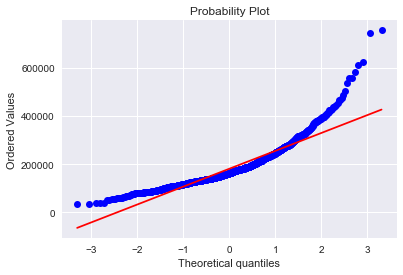

In [150]:
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Although earlier we verified that there is no price that is either negative or zero, we could continue with a simple log transformation, but we will use a log(1+x) to make the solution safer

In [151]:
train["SalePrice"] = np.log1p(train["SalePrice"])
# It's important to remember that log(1 + x), the inverse of expm1.

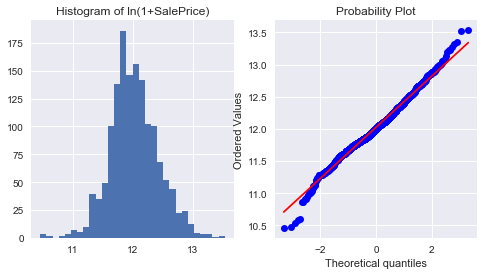

In [152]:
sns.set(rc={'figure.figsize':(8,4)})
plt.subplot(1, 2, 1)
train['SalePrice'].hist(bins=30).plot()
plt.title("Histogram of ln(1+SalePrice)")
plt.subplot(1, 2, 2)
stats.probplot(train['SalePrice'], plot=plt)
plt.show()

As we can see above, after the transformation the target is almost normal

## Train and test concat to analyze other features

Although the act of using test data to analyze data and create null imputation rules can be considered data leakage, it's a common practice in Kaggle competitions in order to achieve better results. In real world modelling it would not be used

In [153]:
train.shape

(1460, 80)

In [154]:
test.shape

(1459, 79)

Since test data has no SalePrice variable, it has one less column

In [155]:
concat = pd.concat((train, test)).reset_index(drop=True)
concat.drop(['SalePrice'], axis=1, inplace=True)
concat.shape

(2919, 79)

## Now it's time to look a bit closer on correlations

Before diving deeper on correlation, let´s take a look at the different lists of variable's labels that we will create

In [156]:
remove_multicolinearity = [] #Variables that will be removed from the model because of multicolinearity
remove_categorical = [] # Categorical variables that will not be usued on the model
remove_null = [] # Variables that will be removed due to high frequency of nulls

The correlation matrix will use train data, because we want to be able to analyze the correlation of the numerical variables with SalePrice

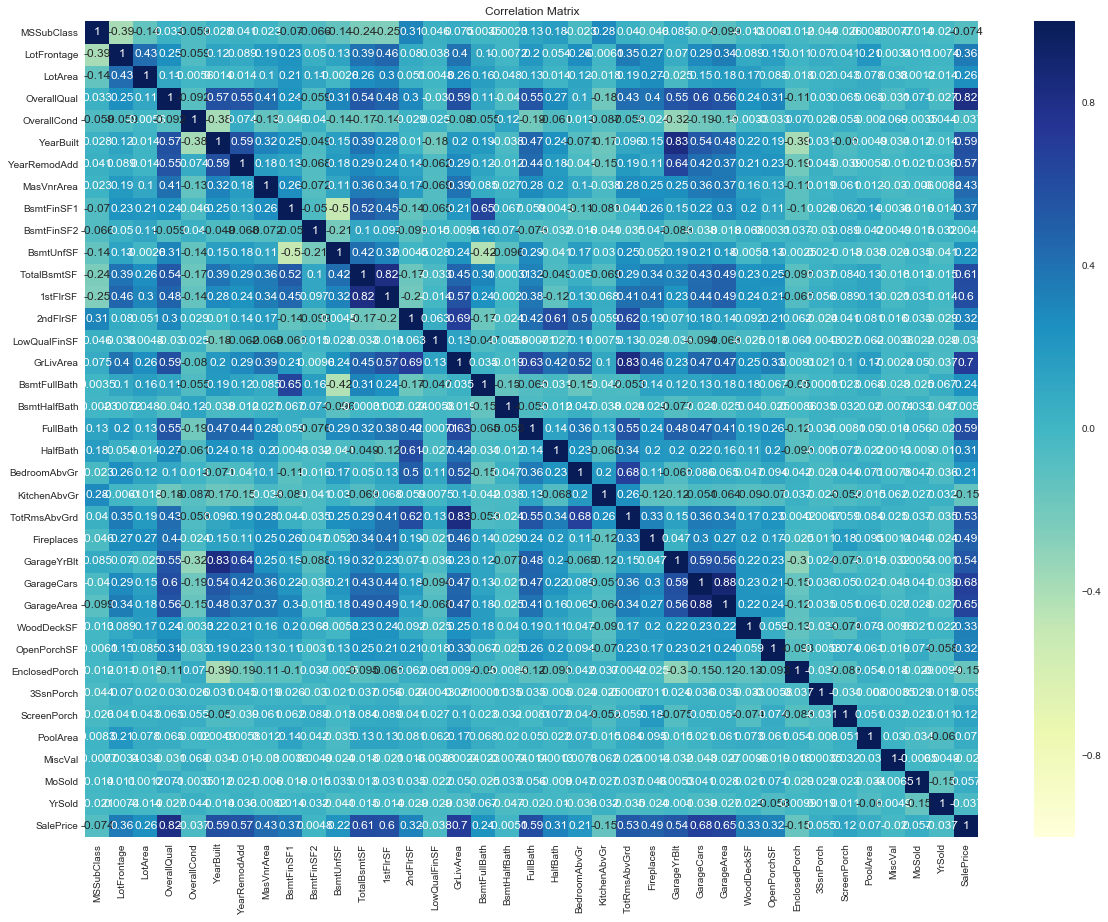

In [157]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix")
plt.show()

The correlation plot above was created only to have an idea of correlation between variables. Although we have some interesting correlations that needs to be investigated deeper, at this moment we will focus the investigation on the variables that are highly correlated with the SalesPrice.
* OverallQual
* TotalBsmtSF
* GrLivArea
* GarageCars

In [158]:
temp = train.loc[:,['OverallQual','TotalBsmtSF','GrLivArea','GarageCars', 'SalePrice']]

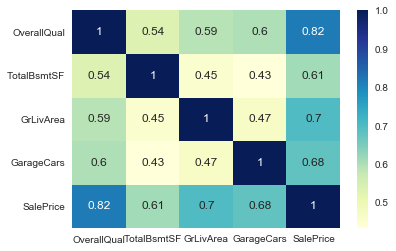

In [159]:
plt.subplots(figsize=(6,4))
sns.heatmap(temp.corr(), cmap="YlGnBu", annot=True)
plt.show()

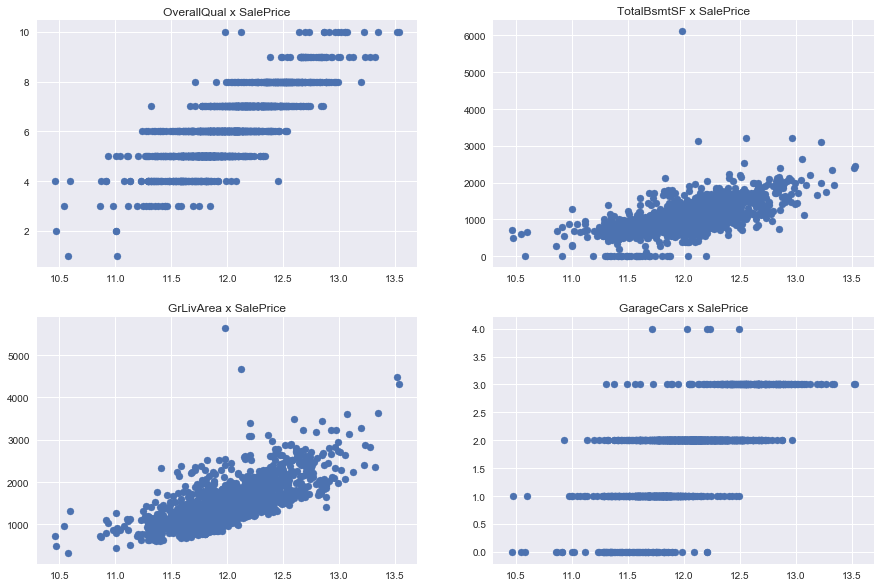

In [160]:
colunas = list(temp.columns)
colunas.remove('SalePrice')

plt.subplots(figsize=(15,10))
for n, coluna in enumerate(colunas):
    plt.subplot(2,2,n+1)
    plt.title(coluna + " x SalePrice")
    plt.scatter(x=temp['SalePrice'], y=temp[coluna])
    
plt.show()

**OverallQual:** This numerical variable will be transformed to an ordered categorical variable. But  it´s interesting to note that it has an almost linear correlation with the price

**TotalBsmtSF** This variable has a positive relationship with price. There is an interesting outlier that is a building with a very big basement, but I will keep it

**GrLivArea** and **GarageCars** are very correlated with the price as well with no outlier to be removed

From the above, only OverallQual and GarageCars are in my list of High Importance vars on "variable_description.xlsx" file. It´s important to mention that I ranked the variables in the spreadsheet prior to analysing the data, so it's only a personal feeling on the variable importance.

In [161]:
# Convert to Ordered Category
concat["OverallQual"]=concat["OverallQual"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10])

### From now on we will analyze all pairs of variables that have correlation greater than 0.8 because they can bring multicolinearity problems to the model

In [162]:
#GarageArea Vs GarageCars, 
#GarageCars has a bigger correlation with the target
remove_multicolinearity.append("GarageArea")

In [163]:
# YearBuilt has a bigger correlation with the target
remove_multicolinearity.append("GarageYrBlt")

In [164]:
#GrLivArea Vs TotRmsAbvGrd
#GrLivArea has a bigger correlation with the target
remove_multicolinearity.append("TotRmsAbvGrd")

In [165]:
#1stFlrSF Vs TotalBsmtSF
#TotalBsmtSF has a bigger correlation with the target
remove_multicolinearity.append("1stFlrSF")

In [166]:
remove_multicolinearity

['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF']

#### Converting Numerical to Categorical

In [167]:
concat["MSSubClass"]=concat["MSSubClass"].astype('category', ordered=False)
concat["OverallCond"]=concat["OverallCond"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10])
concat["MoSold"]=concat["MoSold"].astype('category', ordered=True, categories=[1,2,3,4,5,6,7,8,9,10,11,12])

In [168]:
concat.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 79 entries, 1stFlrSF to YrSold
dtypes: category(4), float64(11), int64(21), object(43)
memory usage: 1.7+ MB


## Before advancing to categorical variables, let´s take a look at nulls

### List of columns with nulls

In [169]:
train.columns[train.isnull().sum()>0].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

#### The graph below shows bars with the number of no null observations per variable. We will present only the variables that have at least 1 null observation

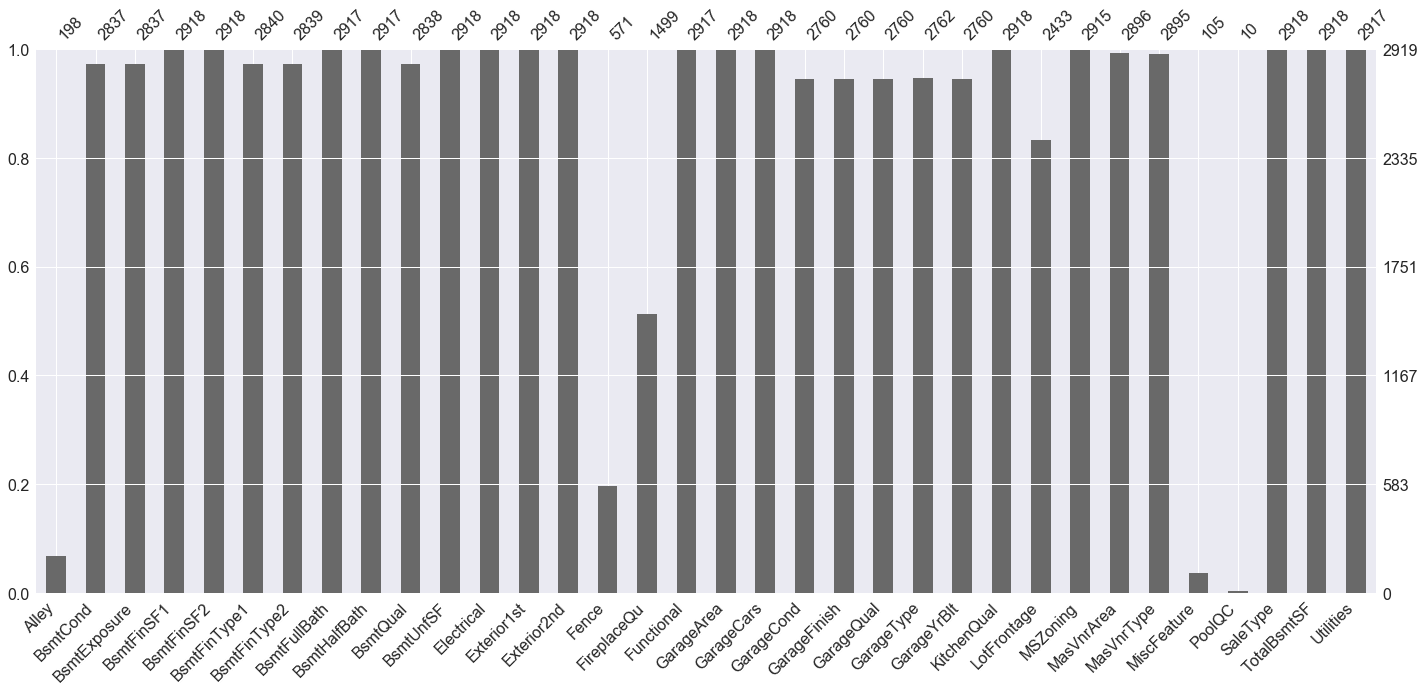

In [170]:
msno.bar(concat.loc[:,concat.columns[concat.isnull().sum()>0].tolist()])

According to the data_description file, some nulls makes sense, so we will analyze them one by one, starting with the ones that we know what to do with

In [171]:
# Alley : NA means No Alley access
concat["Alley"].fillna("No Alley", inplace=True)

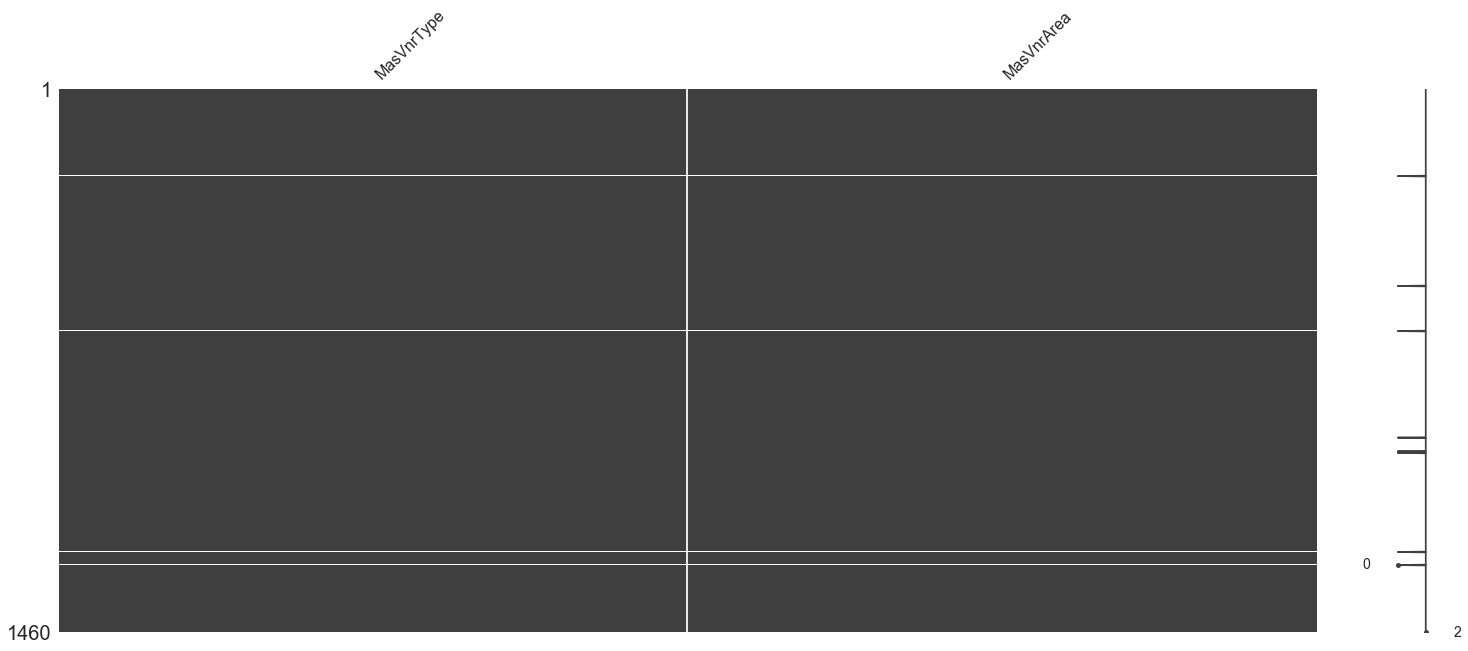

In [172]:
# MasVnrType and MasVnrArea have almost the same amount of nulls. I will check if they are the same observations. 
msno.matrix(train.loc[:,["MasVnrType", "MasVnrArea"]])
plt.show()

Above we can see that on train dataset they have exactly the same nulls, but below, when we take a look at both train and test data, we have differences

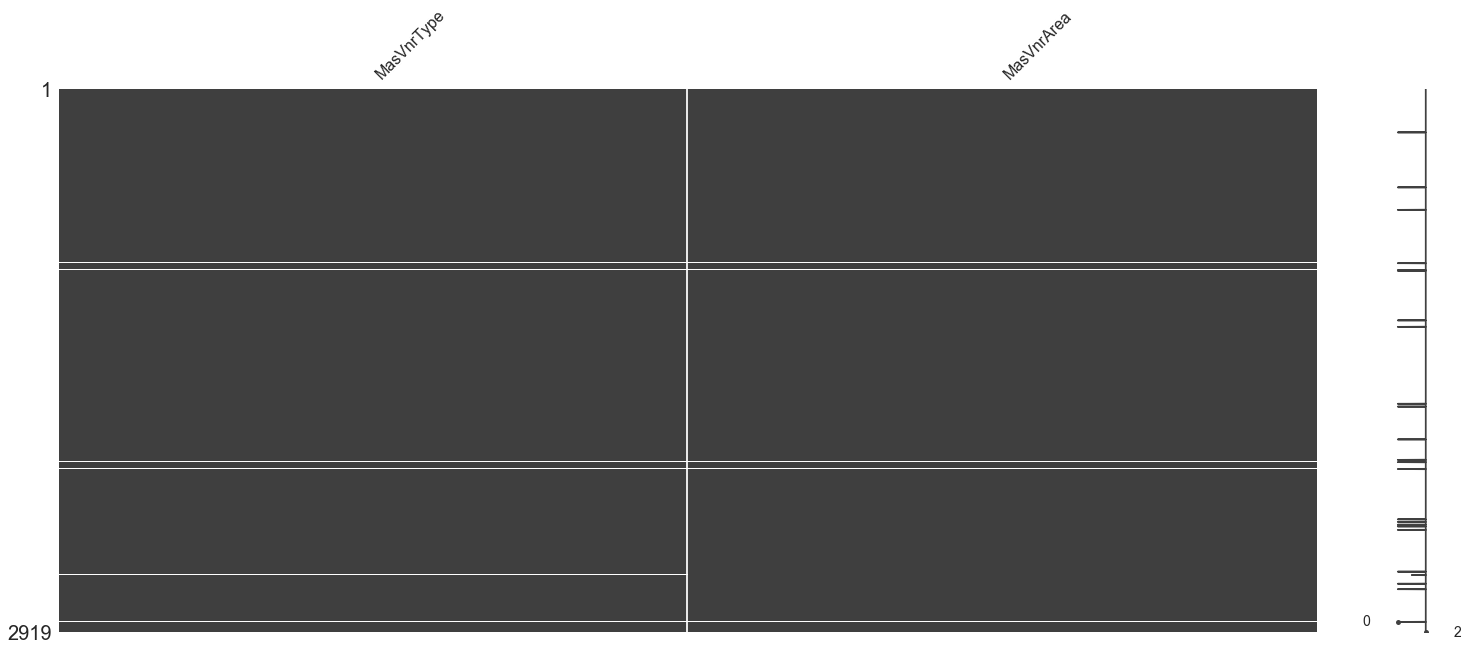

In [173]:
# MasVnrType and MasVnrArea have almost the same amount of nulls. I will check if they are the same observations. 
msno.matrix(concat.loc[:,["MasVnrType", "MasVnrArea"]])
plt.show()

It´s not safe to drop them, so we will assume 0 as null for area and None for Area

In [174]:
# MasVnrType and MasVnrArea
concat["MasVnrType"].fillna("None", inplace=True)
concat["MasVnrArea"].fillna(0, inplace=True)

In [175]:
# BsmtQual : NA means No basement
concat["BsmtQual"].fillna("No Basement", inplace=True)

In [176]:
# BsmtCond : NA means No basement
concat["BsmtCond"].fillna("No Basement", inplace=True)

In [177]:
# BsmtExposure : NA means No basement
concat["BsmtExposure"].fillna("No Basement", inplace=True)

In [178]:
#  BsmtFinType1 : NA means No basement
concat["BsmtFinType1"].fillna("No Basement", inplace=True)

In [179]:
#  BsmtFinType2 : NA means No basement
concat["BsmtFinType2"].fillna("No Basement", inplace=True)

In [180]:
#Electrical have only 1 missing value so I will replace with the most common
concat["Electrical"].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [181]:
concat["Electrical"].fillna("SBrkr", inplace=True)

In [182]:
#FireplaceQu : NA means No fireplace
concat["FireplaceQu"].fillna("No fireplace", inplace=True)

In [183]:
#GarageType : NA means No garage
concat["GarageType"].fillna("No garage", inplace=True)

In [184]:
#GarageFinish : NA means No garage
concat["GarageFinish"].fillna("No garage", inplace=True)

In [185]:
#GarageQual : NA means No garage
concat["GarageQual"].fillna("No garage", inplace=True)

In [186]:
#GarageCond : NA means No garage
concat["GarageCond"].fillna("No garage", inplace=True)

In [187]:
#PoolQC : NA means No pool
concat["PoolQC"].fillna("No pool", inplace=True)

In [188]:
#Fence : NA means No fence
concat["Fence"].fillna("No fence", inplace=True)

In [189]:
#MiscFeature : NA means None
concat["MiscFeature"].fillna("None", inplace=True)

In [190]:
#LotFrontage : Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
concat["LotFrontage"] = concat.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [191]:
#LGarageYrBlt : As we can see below, all garages that do not have a Year Built, does not exist (has 0 size in cars)
train.loc[train["GarageYrBlt"].isnull(),["GarageYrBlt", "GarageCars"]]["GarageCars"].sum()

0

In [192]:
#LGarageYrBlt : Based on the above, we will fill nulls with 0
concat["GarageYrBlt"].fillna(0, inplace=True)

In [193]:
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values will be replaced by 0
for coluna in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    concat[coluna].fillna(0, inplace=True)

In [194]:
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : Null mean No basement
for coluna in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    concat[coluna].fillna("No Basement", inplace=True)

In [195]:
#Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will replace with the most common
# Instead of counting the values of each category from the categoricals, I will use mode this time
concat['Exterior1st'].fillna(concat['Exterior1st'].mode()[0], inplace=True)
concat['Exterior2nd'].fillna(concat['Exterior2nd'].mode()[0], inplace=True)

In [196]:
# Functional : description file says NA means typical
concat["Functional"].fillna("Typ", inplace=True)

In [197]:
#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for coluna in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concat[coluna].fillna(0, inplace=True)

In [198]:
#KitchenQual, MSZoning,SaleType : We will use mode
concat['KitchenQual'].fillna(concat['KitchenQual'].mode()[0], inplace=True)
concat['MSZoning'].fillna(concat['MSZoning'].mode()[0], inplace=True)
concat['SaleType'].fillna(concat['SaleType'].mode()[0], inplace=True)

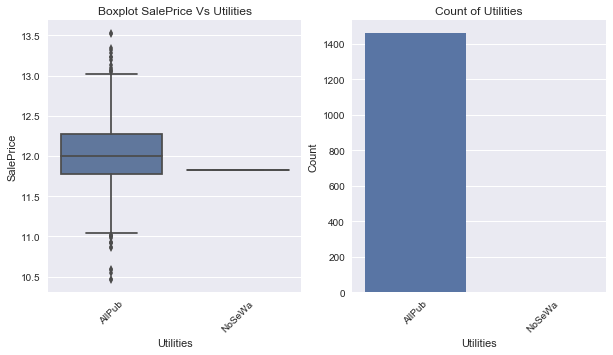

In [199]:
#Utilities: This one we will not fill nulls because it will be dropped later
y="SalePrice"
x="Utilities"
categorical_analizator(x=x, y=y, data=train)

## Time to analyze categorical data

### Starting with the ones that I have high expectation

In [200]:
def boxplotator(x,y,data,order=None,title="",xlabel="",ylabel=""):
    sns.boxplot(x=x, y=y, 
                order=order,
                data=data, saturation=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

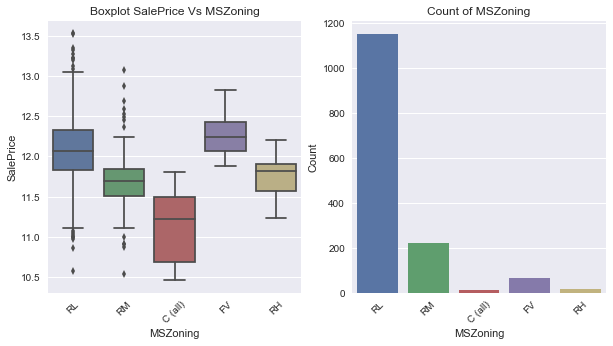

In [201]:
y="SalePrice"
x="MSZoning"
categorical_analizator(x=x, y=y, data=train)

Commercial have lower prices than others. Residential Low Density and fluvial have slightly higher prices

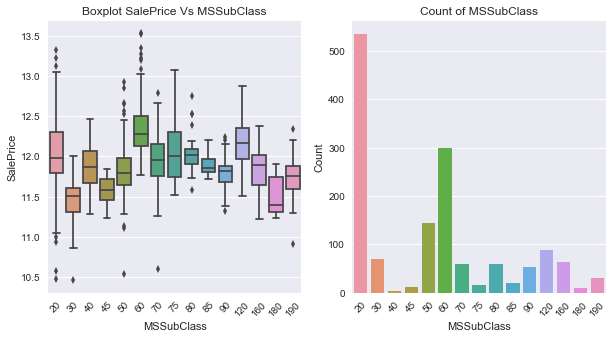

In [202]:
y="SalePrice"
x="MSSubClass"
categorical_analizator(x=x, y=y, data=train)

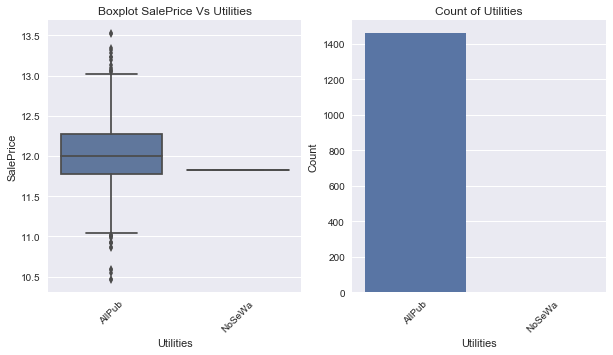

In [203]:
y="SalePrice"
x="Utilities"
categorical_analizator(x=x, y=y, data=train)

This categorical have a high concentration on only one category so it will be removed

In [204]:
remove_categorical.append("Utilities")

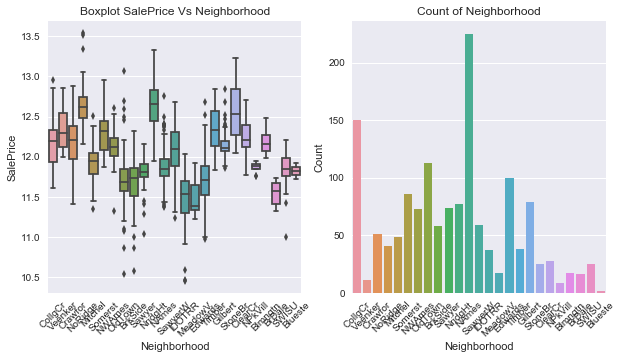

In [205]:
y="SalePrice"
x="Neighborhood"
categorical_analizator(x=x, y=y, data=train)

As expected some Neighborhoods have higher/lower prices

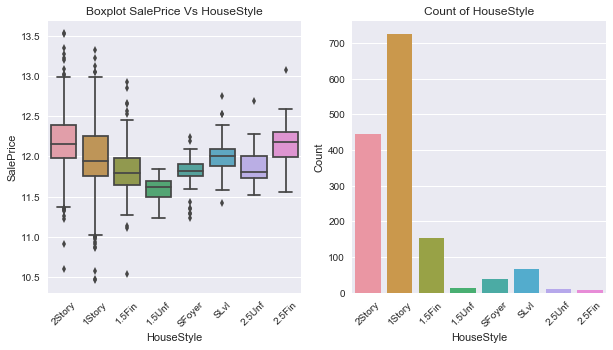

In [206]:
y="SalePrice"
x="HouseStyle"
categorical_analizator(x=x, y=y, data=train)

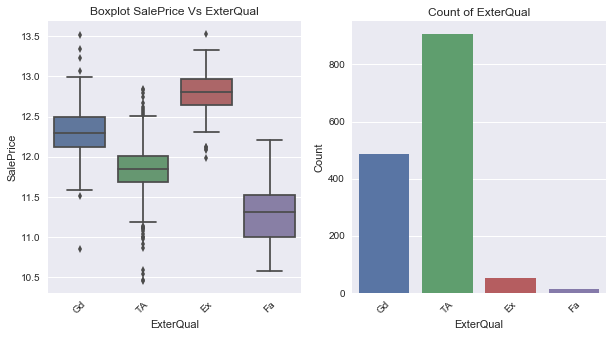

In [207]:
y="SalePrice"
x="ExterQual"
categorical_analizator(x=x, y=y, data=train)

### Now we will analyze the ones that I have medium expectation

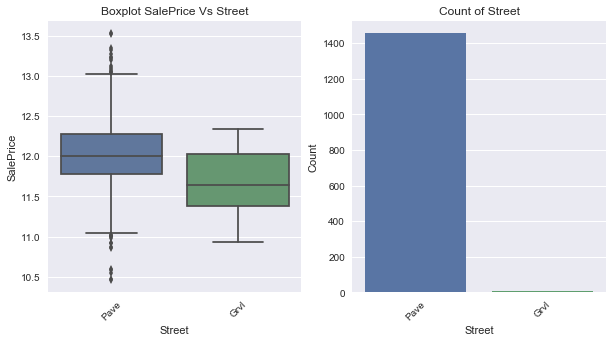

In [208]:
y="SalePrice"
x="Street"
categorical_analizator(x=x, y=y, data=train)

This categorical have a high concentration on only one category so it will be removed

In [209]:
remove_categorical.append(x)

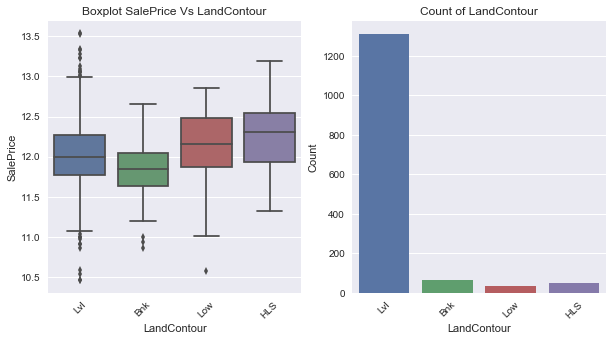

In [210]:
x="LandContour"
categorical_analizator(x=x, y=y, data=train)

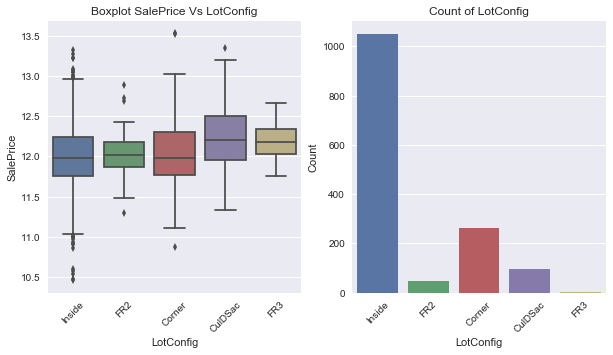

In [211]:
x="LotConfig"
y="SalePrice"
categorical_analizator(x=x, y=y, data=train)

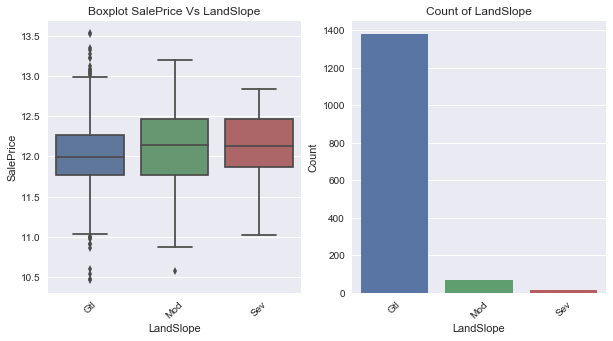

In [212]:
x="LandSlope"
categorical_analizator(x=x, y=y, data=train)

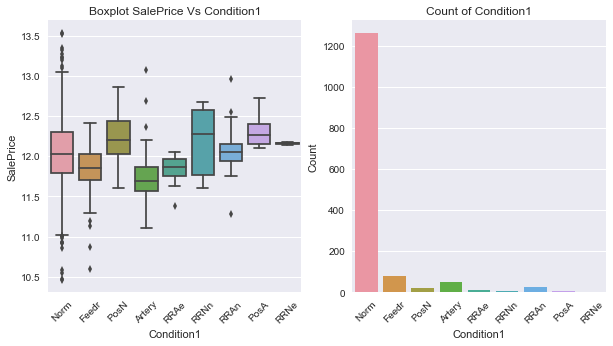

In [213]:
x="Condition1"
categorical_analizator(x=x, y=y, data=train)

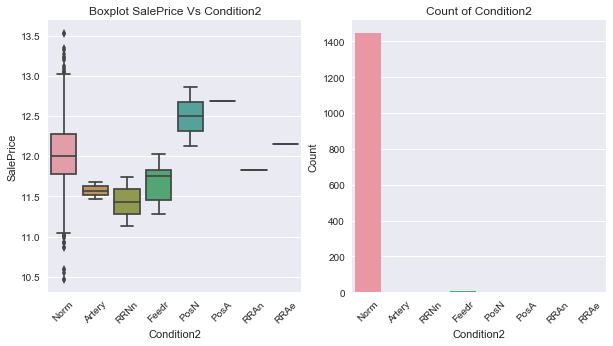

In [214]:
x="Condition2"
categorical_analizator(x=x, y=y, data=train)

In [215]:
remove_categorical.append(x)

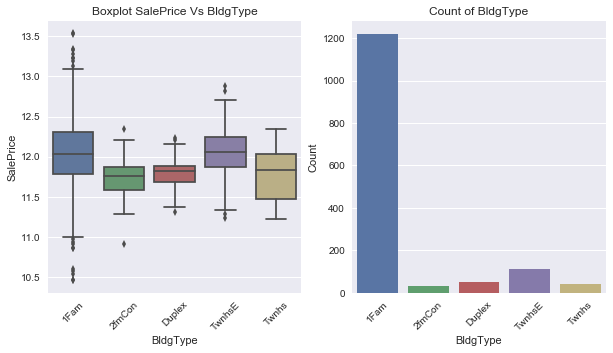

In [216]:
x="BldgType"
categorical_analizator(x=x, y=y, data=train)

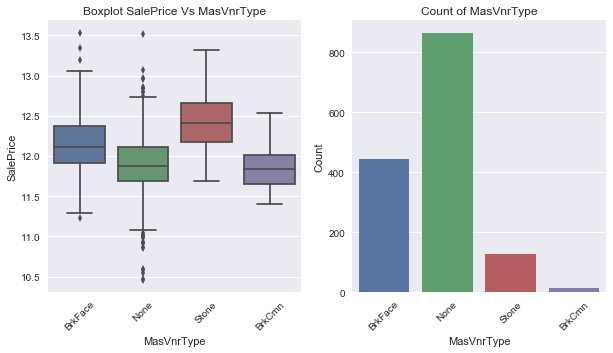

In [217]:
x="MasVnrType"
categorical_analizator(x=x, y=y, data=train)

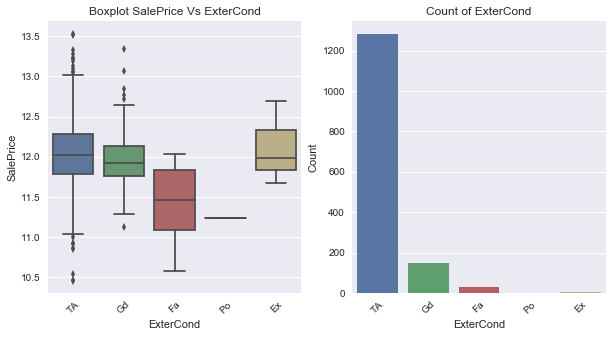

In [218]:
x="ExterCond"
categorical_analizator(x=x, y=y, data=train)

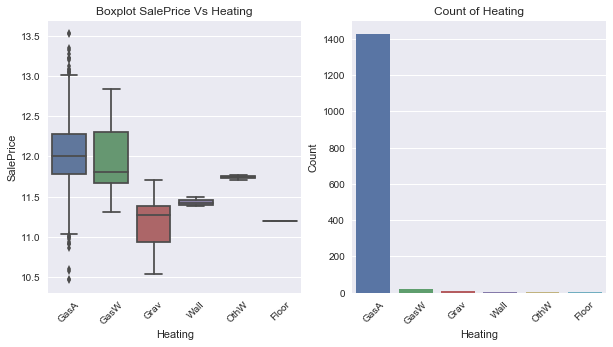

In [219]:
x="Heating"
categorical_analizator(x=x, y=y, data=train)

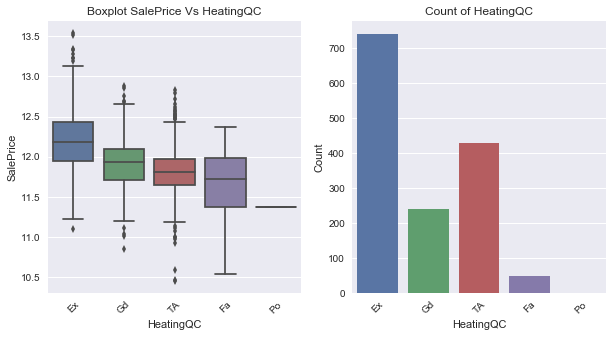

In [220]:
x="HeatingQC"
categorical_analizator(x=x, y=y, data=train)

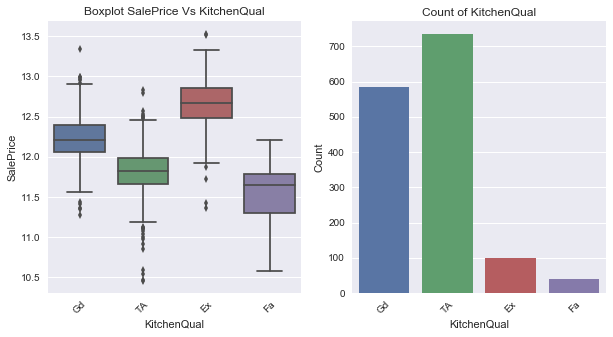

In [221]:
x="KitchenQual"
categorical_analizator(x=x, y=y, data=train)

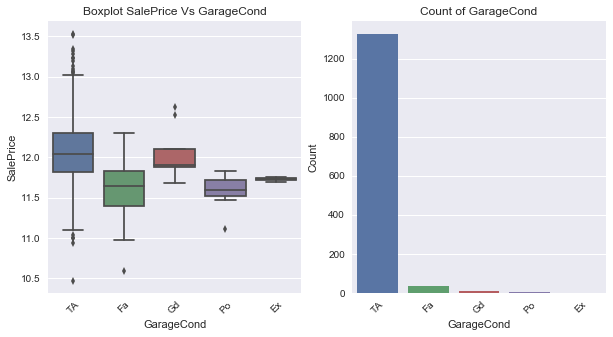

In [222]:
x="GarageCond"
categorical_analizator(x=x, y=y, data=train)

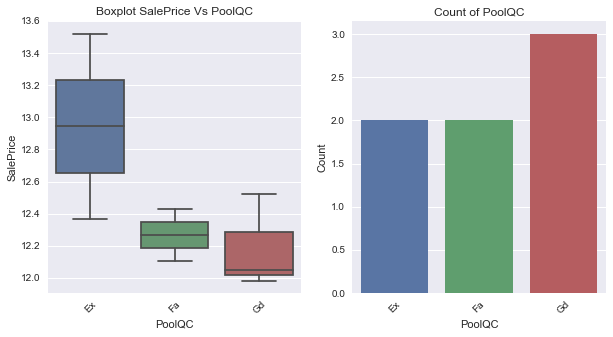

In [223]:
x="PoolQC"
categorical_analizator(x=x, y=y, data=train)

In [224]:
remove_categorical.append(x)

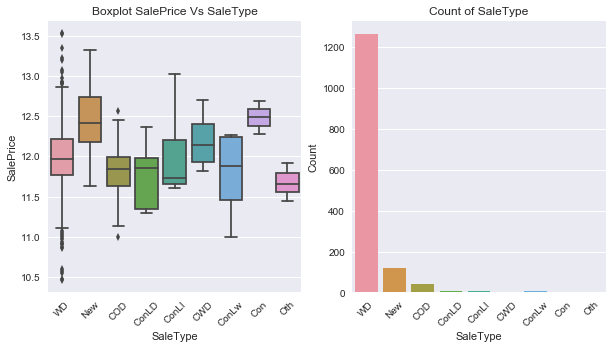

In [225]:
x="SaleType"
categorical_analizator(x=x, y=y, data=train)

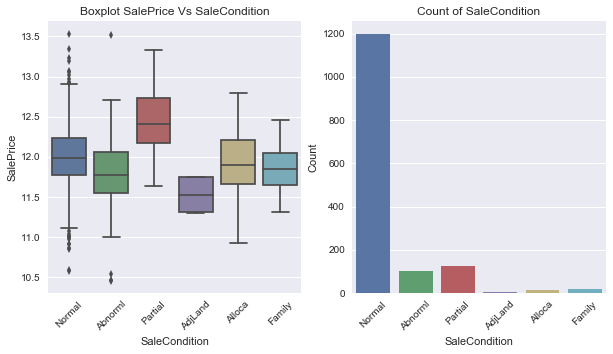

In [226]:
x="SaleCondition"
categorical_analizator(x=x, y=y, data=train)

### Now it´s time for the low expectation

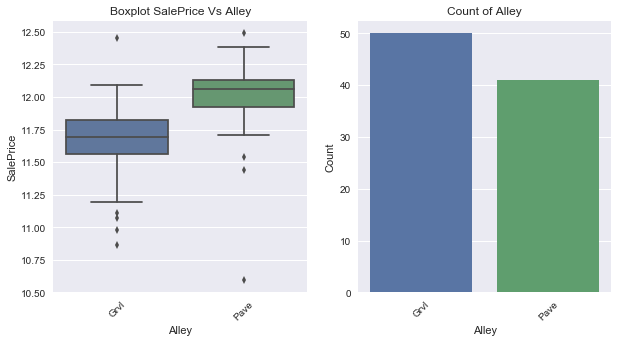

In [227]:
x="Alley"
categorical_analizator(x=x, y=y, data=train)

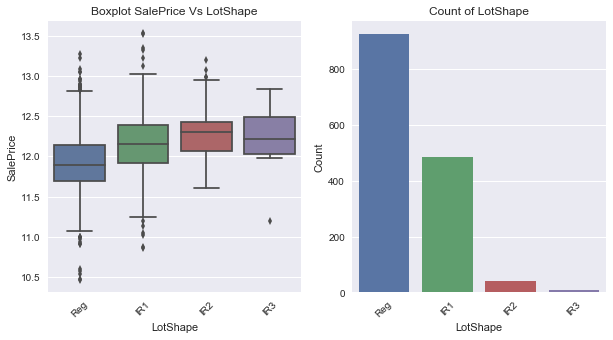

In [228]:
x="LotShape"
categorical_analizator(x=x, y=y, data=train)

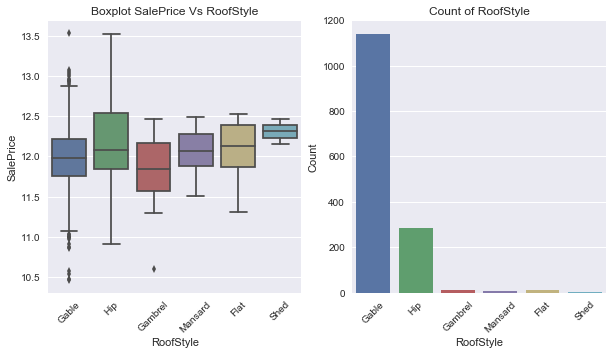

In [229]:
x="RoofStyle"
categorical_analizator(x=x, y=y, data=train)

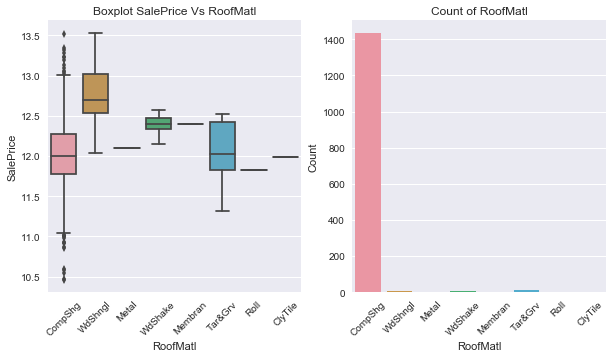

In [230]:
x="RoofMatl"
categorical_analizator(x=x, y=y, data=train)

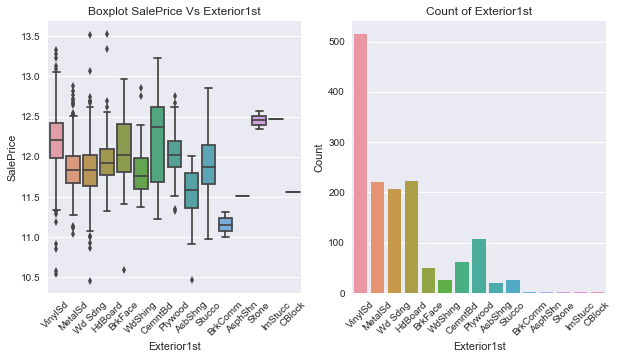

In [231]:
x="Exterior1st"
categorical_analizator(x=x, y=y, data=train)

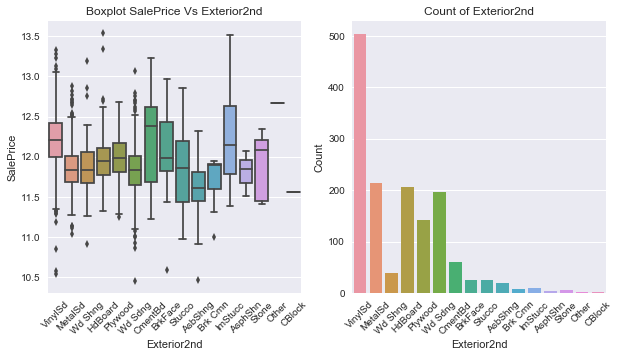

In [232]:
x="Exterior2nd"
categorical_analizator(x=x, y=y, data=train)

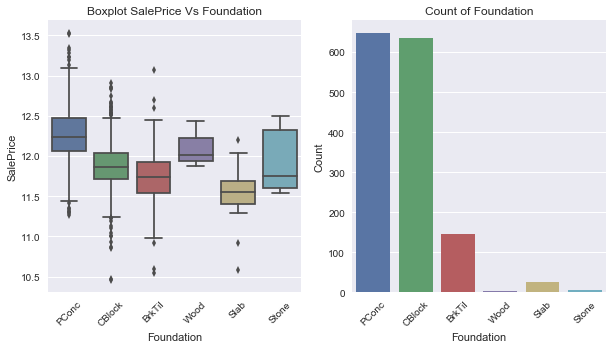

In [233]:
x="Foundation"
categorical_analizator(x=x, y=y, data=train)

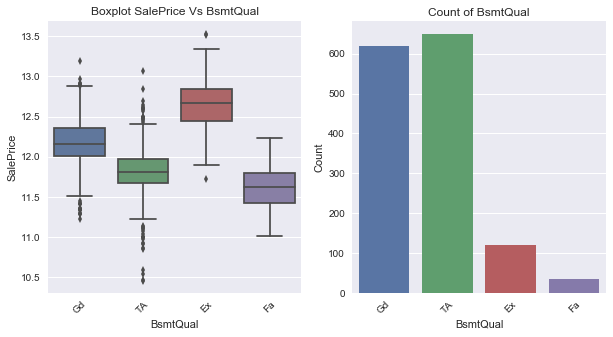

In [234]:
x="BsmtQual"
categorical_analizator(x=x, y=y, data=train)

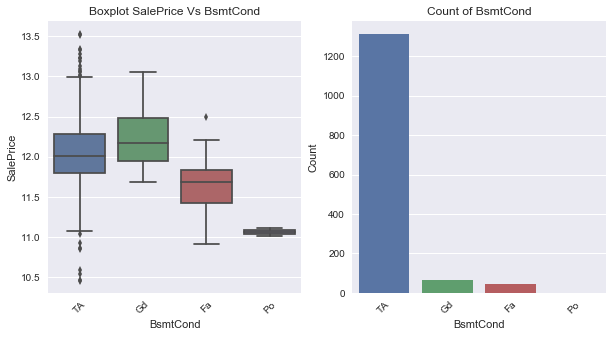

In [235]:
x="BsmtCond"
categorical_analizator(x=x, y=y, data=train)

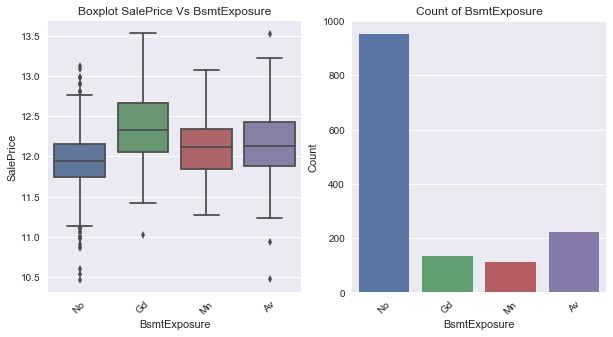

In [236]:
x="BsmtExposure"
categorical_analizator(x=x, y=y, data=train)

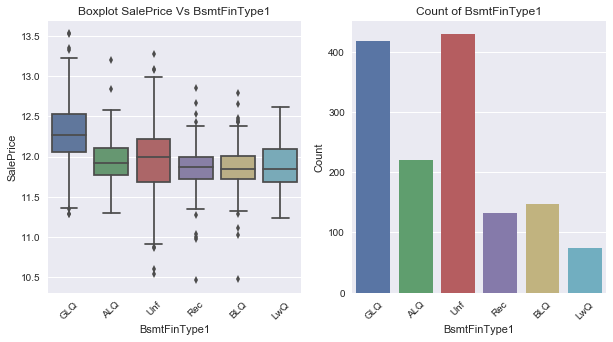

In [237]:
x="BsmtFinType1"
categorical_analizator(x=x, y=y, data=train)

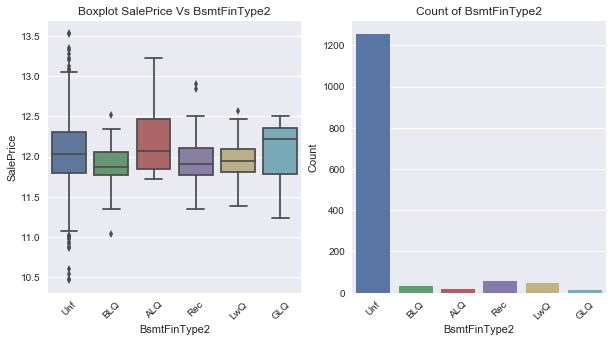

In [238]:
x="BsmtFinType2"
categorical_analizator(x=x, y=y, data=train)

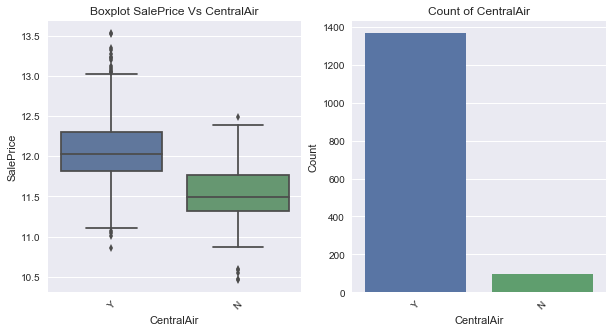

In [239]:
x="CentralAir"
categorical_analizator(x=x, y=y, data=train)

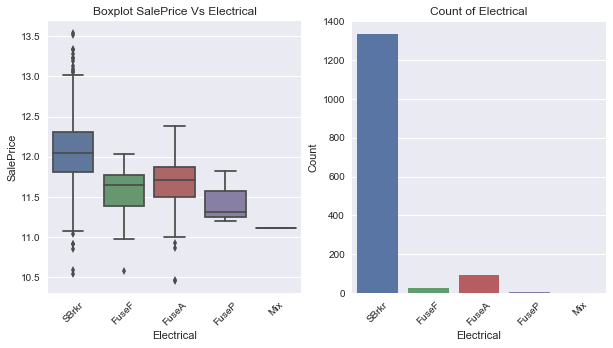

In [240]:
x="Electrical"
categorical_analizator(x=x, y=y, data=train)

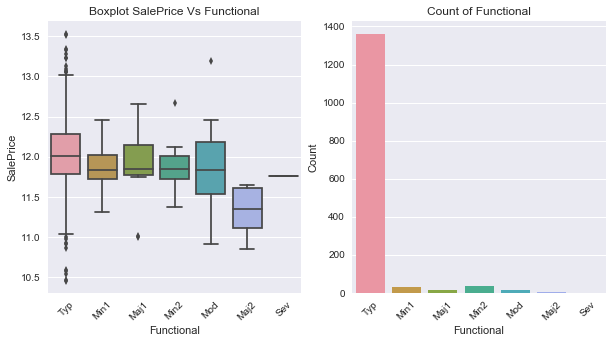

In [241]:
x="Functional"
categorical_analizator(x=x, y=y, data=train)

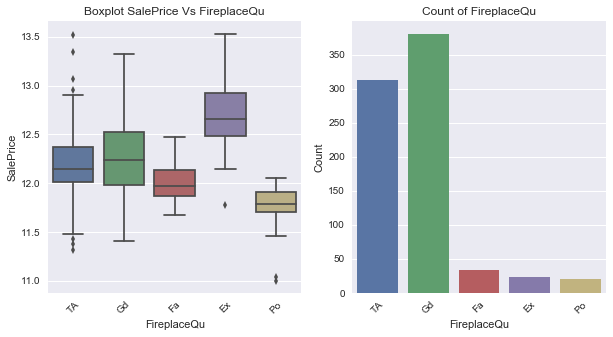

In [242]:
x="FireplaceQu"
categorical_analizator(x=x, y=y, data=train)

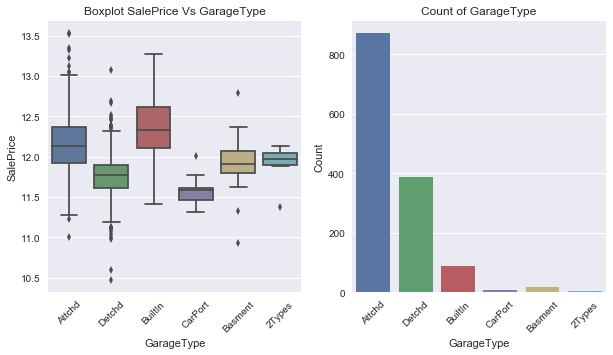

In [243]:
x="GarageType"
categorical_analizator(x=x, y=y, data=train)

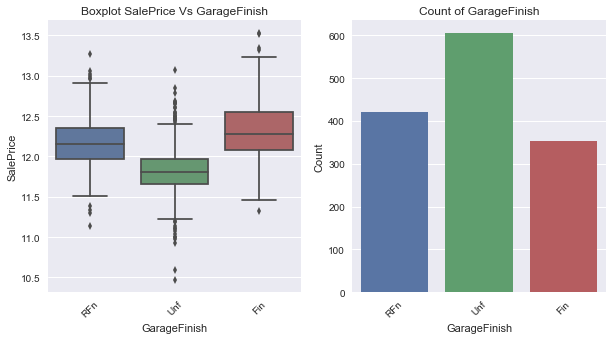

In [244]:
x="GarageFinish"
categorical_analizator(x=x, y=y, data=train)

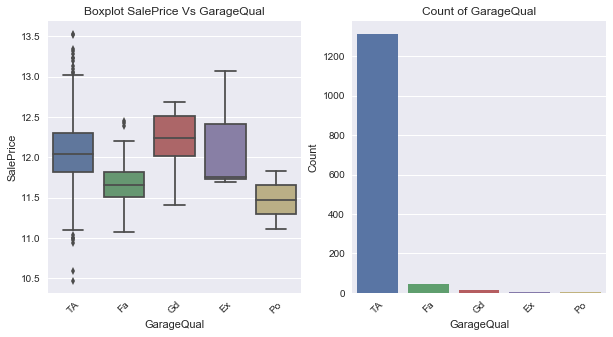

In [245]:
x="GarageQual"
categorical_analizator(x=x, y=y, data=train)

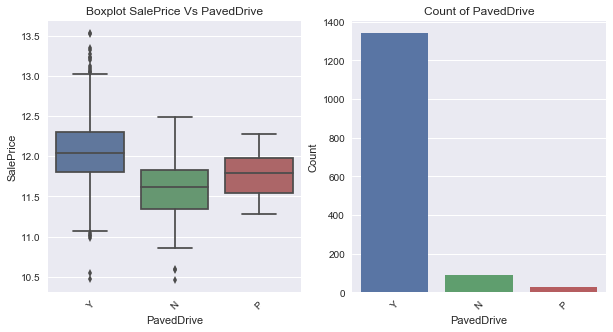

In [246]:
x="PavedDrive"
categorical_analizator(x=x, y=y, data=train)

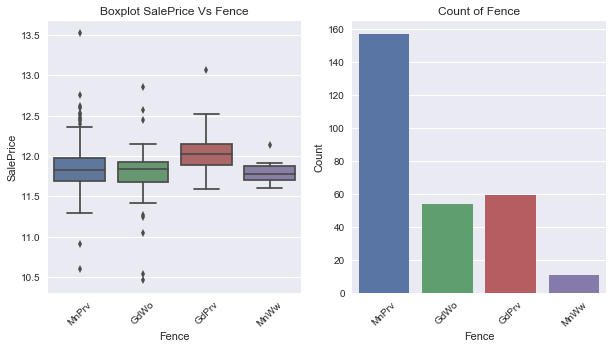

In [247]:
x="Fence"
categorical_analizator(x=x, y=y, data=train)

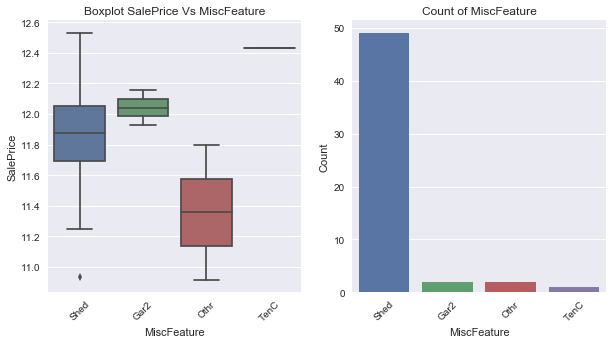

In [248]:
x="MiscFeature"
categorical_analizator(x=x, y=y, data=train)

In [249]:
remove_multicolinearity

['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF']

In [250]:
remove_categorical

['Utilities', 'Street', 'Condition2', 'PoolQC']

# MODEL TIME

Storing the target separate from the trainning dataframe

In [185]:
y_train=train['SalePrice']
X_train = train.loc[:, train.columns != 'SalePrice']

Remove columns that are not going to be used on the model

In [186]:
X_train.shape[1]

79

In [187]:
X_train=X_train.loc[:,X_train.columns.difference(remove_multicolinearity)]
X_train.shape[1]

75

In [189]:
X_train=X_train.loc[:,X_train.columns.difference(remove_categorical)]
X_train.shape[1]

71

In [193]:

from  sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mse', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='mse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


In [ ]:
aaa

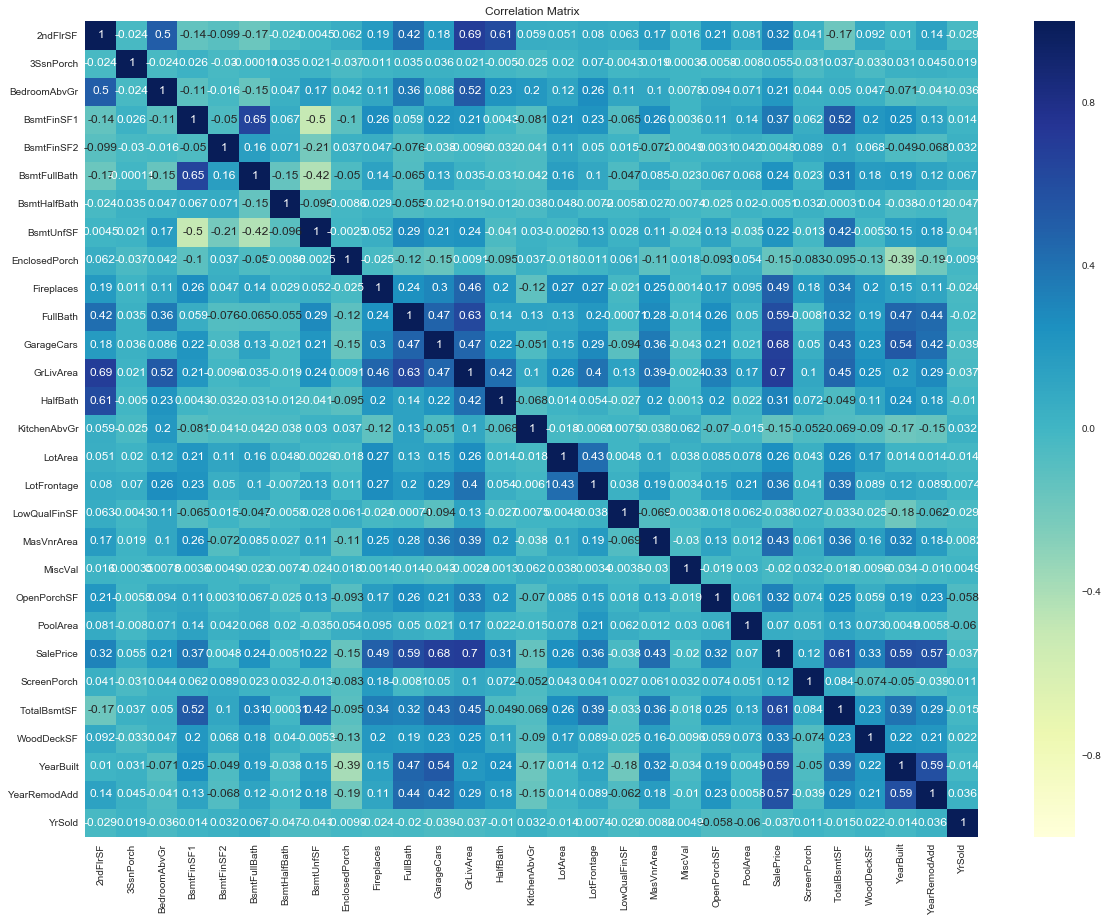

In [53]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.loc[:,train.columns.difference(remove_multicolinearity)].corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix")
plt.show()

In [51]:
train["MSSubClass"].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

Looking a bit closer we can see that GarageCars and GarageArea have 0.88 correlation and this is too high. GarageCars is more correlated with SalePrice than GarageArea, so maybe it's a better predictor for SalePrice. The same occurs with TotalBsmtSF and 1stFlrSF

Let's take a look at nulls

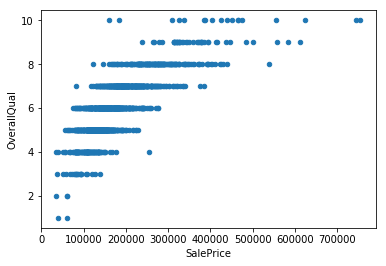

In [41]:
temp.plot(kind='scatter', x='SalePrice', y='OverallQual')

TypeError: 'str' object is not callable

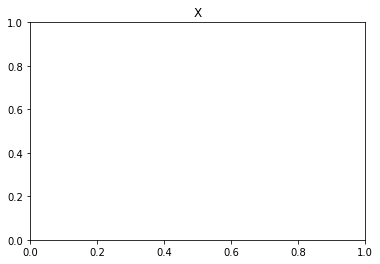

In [46]:
plt.title("X")
plt.xlabel("ASda")
plt.scatter(x=temp['SalePrice'], y=temp['OverallQual'])

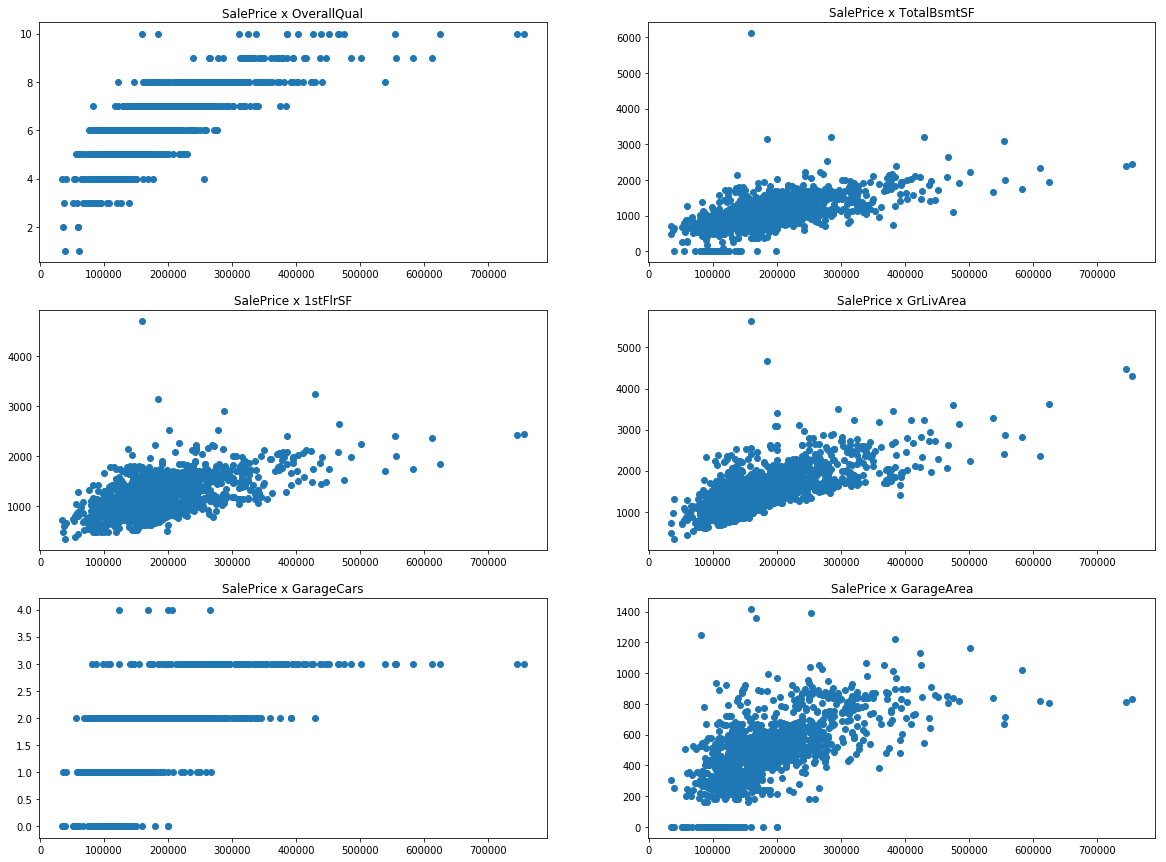

In [52]:
colunas = list(temp.columns)
colunas.remove('SalePrice')

plt.subplots(figsize=(20,15))
for n, coluna in enumerate(colunas):
    plt.subplot(3,2,n+1)
    plt.title("SalePrice x " + coluna)
    plt.scatter(x=temp['SalePrice'], y=temp[coluna])
    
plt.show()

In [ ]:
plt.subplot(321)
plt.scatter(x, y, s=80, c=z, marker=">")

plt.subplot(322)
plt.scatter(x, y, s=80, c=z, marker=(5, 0))

verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
plt.subplot(323)
plt.scatter(x, y, s=80, c=z, marker=verts)

plt.subplot(324)
plt.scatter(x, y, s=80, c=z, marker=(5, 1))

plt.subplot(325)
plt.scatter(x, y, s=80, c=z, marker='+')

plt.subplot(326)
plt.scatter(x, y, s=80, c=z, marker=(5, 2))

plt.show()